In [132]:
import inspect
import json
from os.path import join as pjoin

import numpy as np
from copy import deepcopy

from pygments import highlight
from pygments.lexers.python import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

from matplotlib import pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

In [2]:
with open("data/paths.json") as handle:
    paths = json.load(handle)
paths

{'data': 'data',
 'sample': 'data/sample',
 'sample/train': 'data/sample/train',
 'sample/valid': 'data/sample/valid',
 'test': 'data/test',
 'train': 'data/train',
 'valid': 'data/valid'}

In [3]:
def display_python(code):
    formatter = HtmlFormatter()
    x = IPython.display.HTML(
        '<style type="text/css">{}</style>    {}'.format(
            formatter.get_style_defs('.highlight'),
            highlight(code, PythonLexer(), formatter))
        )
    return x
#display_python(inspect.getsource(vgg16))

Because I want to be able to visualise the weight outputs, I need to rewrite the keras VGG implementation to separate out the convolution layer from the activation layers.

In [4]:
"""
The code in this cell is heavily based on the keras Vgg16 code available
in `keras.applications.vgg16`.
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Activation

from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

def VGG16(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.

    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name="vgg_input")
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape, name="vgg_input")
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = Activation("relu", name='block1_conv1_activ')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = Activation("relu", name='block1_conv2_activ')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = Activation("relu", name='block2_conv1_activ')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = Activation("relu", name='block2_conv2activ')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = Activation("relu", name='block3_conv1_activ')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = Activation("relu", name='block3_conv2_activ')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = Activation("relu", name='block3_conv3_activ')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = Activation("relu", name='block4_conv1_activ')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = Activation("relu", name='block4_conv2_activ')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = Activation("relu", name='block4_conv3_activ')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = Activation("relu", name='block5_conv1_activ')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = Activation("relu", name='block5_conv2_activ')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = Activation("relu", name='block5_conv3_activ')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [7]:
model = VGG16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_input (InputLayer)       (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv1_activ (Activati (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_conv2_activ (Activati (None, 224, 224, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
__________

In [8]:
"""
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))
""";

In [9]:
c1 = model.get_layer(name="block1_conv1")

In [10]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
def plot_filters(weights, plot_num=None, ncols=8):
    from math import ceil
    filters, biases = weights
    
    if plot_num is None:
        plot_num = biases.shape[0]
    
    nrows = ceil(plot_num / ncols)
    
    fig, axes = plt.subplots(
        nrows,
        ncols,
        subplot_kw={'xticks': [], 'yticks': []}
        )
    
    def iterate_np(arr, bias, axis=3):
        for i in range(arr.shape[axis]):
            yield arr[:, :, :, i] 

    for ax, filt in zip(axes.flatten(), iterate_np(filters, biases)):
        ax.imshow(deprocess_image(filt))
    return fig, axes
#plt.imshow(c1.get_weights()[0][:,:,:,0]);

In [12]:
filters, biases = c1.get_weights()
filters[:, :, :, 61] + biases[61]

array([[[ 1.16977239,  1.21719348,  1.17487848],
        [ 1.15380692,  1.2031641 ,  1.17965341],
        [ 1.16185558,  1.20770156,  1.17260945]],

       [[ 1.18769789,  1.2326721 ,  1.20317519],
        [ 1.25000501,  1.29822421,  1.28794897],
        [ 1.15606856,  1.1985116 ,  1.17632532]],

       [[ 1.16056466,  1.19699669,  1.15227127],
        [ 1.17928529,  1.21911156,  1.19223392],
        [ 1.14892173,  1.18370795,  1.14517415]]], dtype=float32)

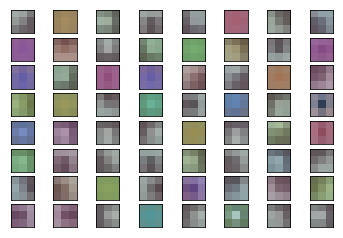

In [13]:
plot_filters(c1.get_weights());

In [14]:
def plot_outputs(image, layer, model, indices, ncols=8, figsize=(15,5)):
    from math import ceil

    if isinstance(indices, int):
        indices = [indices]
    
    if len(image.shape) == 3:
        image = image.reshape((1, 224, 224, 3))
    
    input_layer = model.input
    output_layer = model.get_layer(name=layer).output
    
    trunc_model = Model(inputs=input_layer, outputs=output_layer)
    outputs = trunc_model.predict(image)

    if ncols > len(indices):
        ncols = len(indices)

    nrows = ceil(len(indices) / ncols)
    
    def iterate_np(arr):
        for i in indices:
            yield arr[0, :, :, i]
    
    fig, axes = plt.subplots(
        nrows,
        ncols,
        subplot_kw={'xticks': [], 'yticks': []},
        figsize=figsize
        )
    
    try:
        faxes = axes.flatten()
    except:
        faxes = [axes]
        
    for ax, filt in zip(faxes, iterate_np(outputs)):
        ax.imshow(filt, cmap="Greys")
    return fig, axes

In [15]:
ls data/sample/train/cat

cat.1001.jpg   cat.11683.jpg  cat.3383.jpg  cat.5741.jpg  cat.824.jpg
cat.10257.jpg  cat.11747.jpg  cat.3444.jpg  cat.6191.jpg  cat.8290.jpg
cat.10452.jpg  cat.1175.jpg   cat.3471.jpg  cat.6422.jpg  cat.8595.jpg
cat.10517.jpg  cat.11850.jpg  cat.3917.jpg  cat.6566.jpg  cat.8661.jpg
cat.10660.jpg  cat.11933.jpg  cat.4289.jpg  cat.6676.jpg  cat.890.jpg
cat.1069.jpg   cat.12023.jpg  cat.4403.jpg  cat.6818.jpg  cat.891.jpg
cat.10717.jpg  cat.1210.jpg   cat.4509.jpg  cat.6856.jpg  cat.8935.jpg
cat.10941.jpg  cat.12231.jpg  cat.4814.jpg  cat.6862.jpg  cat.9224.jpg
cat.11034.jpg  cat.12252.jpg  cat.4871.jpg  cat.6927.jpg  cat.9414.jpg
cat.1107.jpg   cat.12363.jpg  cat.5071.jpg  cat.6959.jpg  cat.9422.jpg
cat.11112.jpg  cat.12469.jpg  cat.5077.jpg  cat.7192.jpg  cat.9569.jpg
cat.11194.jpg  cat.161.jpg    cat.5086.jpg  cat.7237.jpg  cat.9764.jpg
cat.11296.jpg  cat.2071.jpg   cat.5210.jpg  cat.7239.jpg  cat.9790.jpg
cat.11397.jpg  cat.3010.jpg   cat.5214.jpg  cat.7244.jpg
cat.11497.jpg  cat.3080

In [16]:
sample = imread(pjoin(paths["sample/train"], "cat", "cat.5077.jpg"))
sample = imresize(sample, size=(224, 224))

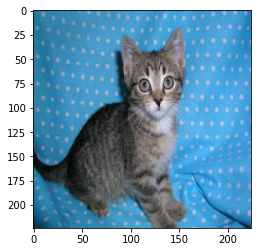

In [17]:
plt.imshow(sample)

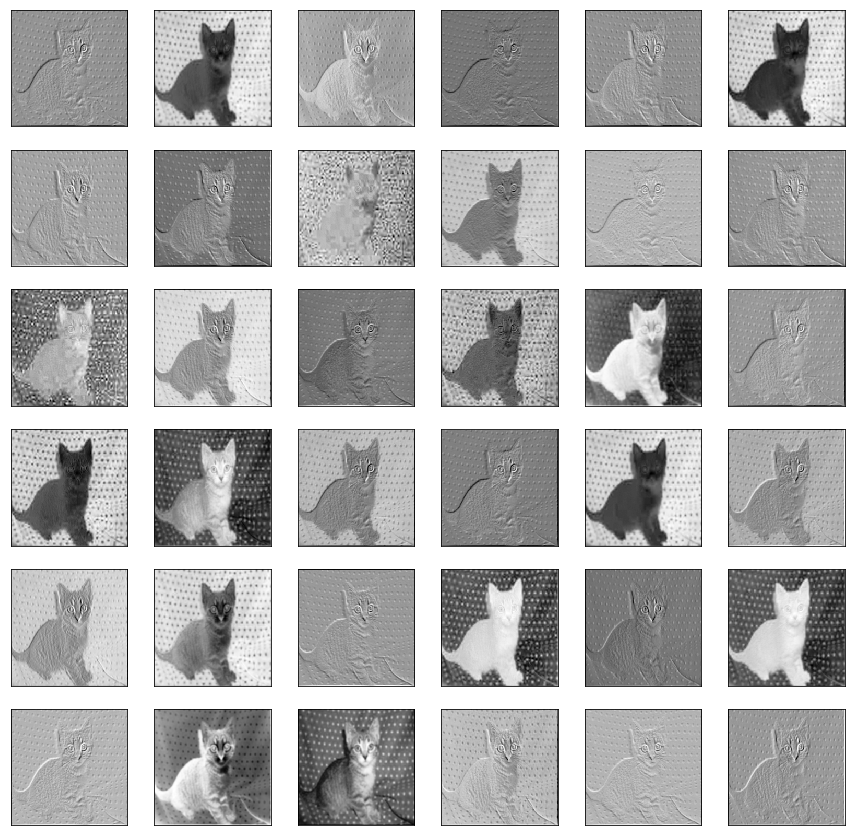

In [18]:
fig, axes = plot_outputs(sample, "block1_conv1", model, range(36), ncols=6, figsize=(15, 15))

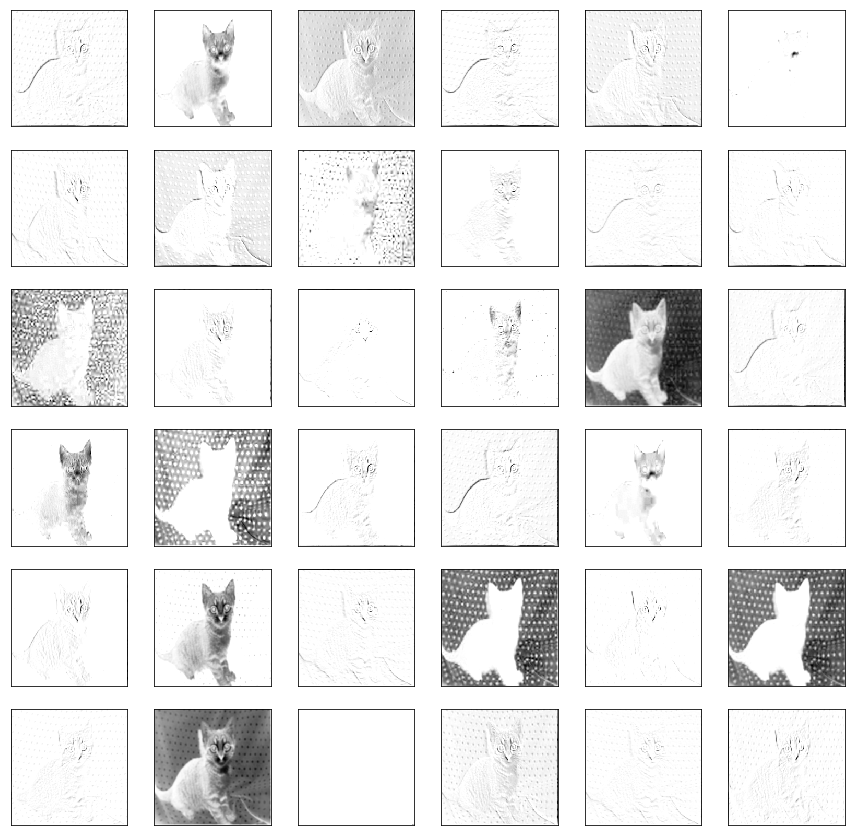

In [19]:
fig, axes = plot_outputs(sample, "block1_conv1_activ", model, range(36),ncols=6, figsize=(15, 15))

[ 42  98  22  47  98 101]


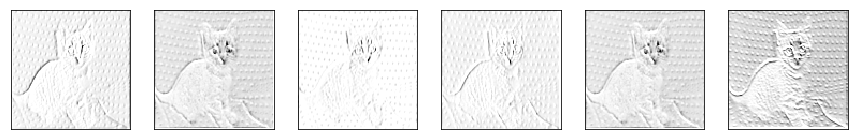

In [20]:
choices = np.random.choice(128, size=6)
print(choices)
fig, axes = plot_outputs(sample, "block2_conv1_activ", model, choices, ncols=6, figsize=(15, 15))

[ 83 228  89 185 104 100]


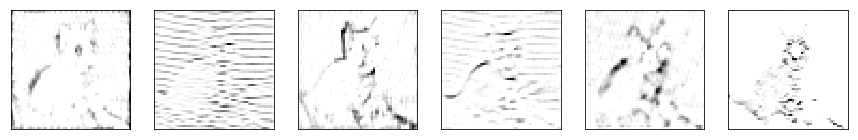

In [21]:
choices = np.random.choice(256, size=6)
print(choices)
fig, axes = plot_outputs(sample, "block3_conv1_activ", model, choices, ncols=6, figsize=(15, 15))

[ 94 133  27 475  73 410]


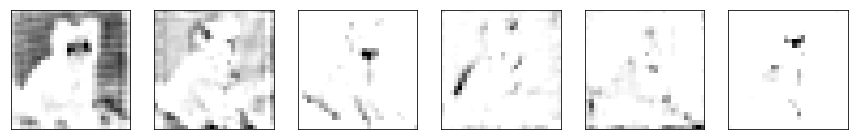

In [22]:
choices = np.random.choice(512, size=6)
print(choices)
fig, axes = plot_outputs(sample, "block4_conv1_activ", model, choices, ncols=6, figsize=(15, 15))

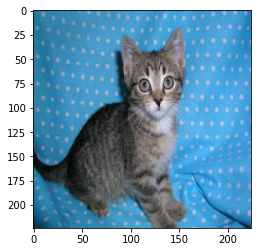

In [23]:
plt.imshow(sample);

[355 361 420 146 442 437]


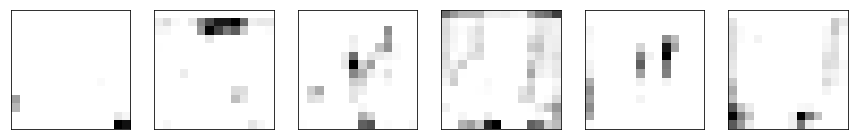

In [24]:
choices = np.random.choice(512, size=6)
print(choices)
plot_outputs(sample, "block5_conv1_activ", model, choices, ncols=6, figsize=(15, 15));

[350 303 394 224 382  85]


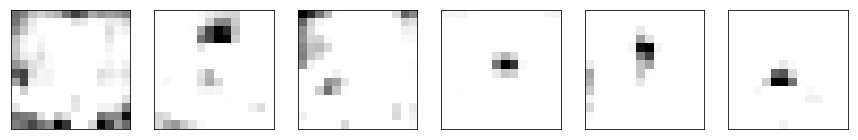

In [89]:
choices = np.random.choice(512, size=6)
print(choices)
plot_outputs(sample, "block5_conv2_activ", model, choices, ncols=6, figsize=(15, 15));

[483  66 400 377 279 353]


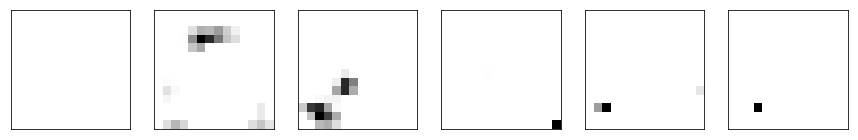

In [116]:
choices = np.random.choice(512, size=6)
print(choices)
plot_outputs(sample, "block5_conv3_activ", model, choices, ncols=6, figsize=(15, 15));

In [175]:
# dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

layer_name = 'block5_conv2_activ'
filter_index = 224  # can be any integer from 0 to 511, as there are 512 filters in that layer

#'block3_conv1_activ' 100 spots takes long time
#'block5_conv2' 382 static from the activation but birds eyes from the weights (with blur and reg get eyes)!
# 'block5_conv1_activ' 361 fabric?
# 'block5_conv1_activ' 442 is scary
#'block4_conv1_activ' 456 is good


# predictions 1 goldfish
# predictions 24: 'great grey owl

input_img=model.input
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = model.get_layer(layer_name).output[:, :, :, filter_index]
#layer_output = model.get_layer(layer_name).output[:, filter_index]
loss = K.mean(layer_output)

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])


# we start from a gray image with some noise
#input_img_data = np.random.random((1, img_width, img_height, 3)) * 20 + 128.
input_img_data = sample.reshape(1, img_width, img_height, 3) * 1.
# run gradient ascent for 20 steps
step = 0.85

ims = [np.copy(input_img_data[0])]
losses = []
for i in range(200):
    loss_value, grads_value = iterate([input_img_data])
    # step size for gradient ascent
    input_img_data += grads_value * step
    losses.append(loss_value)
    ims.append(np.copy(input_img_data[0]))
    
    input_img_data *= 0.9 # L2 reg
    input_img_data = gaussian_filter(input_img_data, sigma=(0, 0.5, 0.5, 0))

In [176]:
fig = plt.figure(figsize=(4, 4))
images = [[plt.imshow(deprocess_image(x), animated=True)] for x in ims]
im_ani = animation.ArtistAnimation(fig, images, interval=100, repeat_delay=1000, blit=True)
plt.close()
IPython.display.HTML(im_ani.to_html5_video())

In [158]:
losses

[0.0013385017,
 0.0011555343,
 0.00094519579,
 0.00086518365,
 0.00080731994,
 0.00077717856,
 0.00077377516,
 0.00077980489,
 0.00079668895,
 0.00082672556,
 0.00086968561,
 0.00090905232,
 0.00093737477,
 0.00094492437,
 0.0009440541,
 0.00093057589,
 0.00090907683,
 0.00096962869,
 0.00092599756,
 0.00091794453,
 0.00080400327,
 0.00094265223,
 0.00089269137,
 0.00086066686,
 0.00076250738,
 0.00089248392,
 0.0008133091,
 0.00064652925,
 0.00079658814,
 0.0009043687,
 0.00083096774,
 0.0010312758,
 0.001260341,
 0.0011244663,
 0.0015249235,
 0.0014404922,
 0.0015133654,
 0.0014372461,
 0.0018336211,
 0.0018640212,
 0.0018682545,
 0.0020162885,
 0.0022632815,
 0.0019264813,
 0.0026988899,
 0.0020967347,
 0.0028760924,
 0.0024796475,
 0.0034981072,
 0.0023418732,
 0.0043964367,
 0.002338036,
 0.0077167591,
 0.0018305511,
 0.013712507,
 0.0010681826,
 0.03467577,
 0.006356793,
 0.061737783,
 0.065292642,
 0.12290744,
 0.33934468,
 0.57708299,
 0.82917249,
 0.91723877,
 0.97841954,
 0.9

In [167]:
np.array(filter_index)

array([382, 224])

In [168]:
model.get_layer(layer_name).output[:, :, :, filter_index]

TypeError: can only concatenate list (not "int") to list